# Reddit Classification Predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import timeit

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# increase columns shown to see all columns 

pd.set_option("display.max_columns", 1000)

In [3]:
reddit = pd.read_csv('./reddit_posts.csv')

In [4]:
reddit.head()

,adserver_click_url,adserver_imp_pixel,archived,author,author_flair_css_class,author_flair_text,contest_mode,created_utc,disable_comments,distinguished,domain,downs,edited,gilded,hide_score,href_url,id,imp_pixel,is_self,link_flair_css_class,link_flair_text,locked,media,media_embed,mobile_ad_url,name,num_comments,original_link,over_18,permalink,post_hint,preview,promoted,promoted_by,promoted_display_name,promoted_url,quarantine,retrieved_on,saved,score,secure_media,secure_media_embed,selftext,spoiler,stickied,subreddit,subreddit_id,third_party_tracking,third_party_tracking_2,thumbnail,title,ups,url
0,NaN,NaN,False,johnnyawesome0,NaN,NaN,False,1480697304,NaN,NaN,self.techsupport,0.0,False,0.0,False,NaN,5g49s2,NaN,True,NaN,NaN,False,NaN,{},NaN,t3_5g49s2,1.0,NaN,False,/r/techsupport/comments/5g49s2/help_with_audio...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.484297e+09,False,1.0,NaN,{},I have a Sony surround sound system for a blu-...,False,False,techsupport,t5_2qioo,NaN,NaN,self,Help with audio set-up,1.0,https://www.reddit.com/r/techsupport/comments/...
1,NaN,NaN,False,Silverfin113,NaN,NaN,False,1480697424,NaN,NaN,self.learnprogramming,0.0,False,0.0,False,NaN,5g4a5p,NaN,True,NaN,NaN,False,NaN,{},NaN,t3_5g4a5p,8.0,NaN,False,/r/learnprogramming/comments/5g4a5p/optimizing...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.484297e+09,False,23.0,NaN,{},I've written what seems to be a prohibitively ...,False,False,learnprogramming,t5_2r7yd,NaN,NaN,self,Optimizing code for speed,23.0,https://www.reddit.com/r/learnprogramming/comm...
2,NaN,NaN,False,bookbooksbooks,NaN,NaN,False,1480697613,NaN,NaN,self.gamedev,0.0,False,0.0,False,NaN,5g4att,NaN,True,discussion cat-talk,Discussion,False,NaN,{},NaN,t3_5g4att,5.0,NaN,False,/r/gamedev/comments/5g4att/seeking_tales_of_de...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.484297e+09,False,12.0,NaN,{},"I'm writing an article called ""Video Games Tha...",False,False,gamedev,t5_2qi0a,NaN,NaN,self,Seeking Tales of Development Woe (and Triumph)...,12.0,https://www.reddit.com/r/gamedev/comments/5g4a...
3,NaN,NaN,False,[deleted],NaN,NaN,False,1480697634,NaN,NaN,self.learnprogramming,0.0,1480698462,0.0,False,NaN,5g4awr,NaN,True,solved,Solved,False,NaN,{},NaN,t3_5g4awr,9.0,NaN,False,/r/learnprogramming/comments/5g4awr/java_findi...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.484297e+09,False,0.0,NaN,{},[deleted],False,False,learnprogramming,t5_2r7yd,NaN,NaN,default,[Java] Finding smallest value in an array,0.0,https://www.reddit.com/r/learnprogramming/comm...
4,NaN,NaN,False,caffeine_potent,NaN,NaN,False,1480697748,NaN,NaN,self.learnpython,0.0,1480709138,0.0,False,NaN,5g4bcr,NaN,True,NaN,NaN,False,NaN,{},NaN,t3_5g4bcr,12.0,NaN,False,/r/learnpython/comments/5g4bcr/currying_functi...,NaN,NaN,NaN,NaN,NaN,NaN,False,1.484297e+09,False,6.0,NaN,{},I have the following representation of argumen...,False,False,learnpython,t5_2r8ot,NaN,NaN,self,currying functions using functools,6.0,https://www.reddit.com/r/learnpython/comments/...


In [5]:
reddit.shape

(26688, 53)

## Features to include

Many of the columns included in this data set have many null values or have little varition. The following section picks out the featues that can be usesful to a model 

In [6]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26688 entries, 0 to 26687
Data columns (total 53 columns):
adserver_click_url        0 non-null float64
adserver_imp_pixel        0 non-null float64
archived                  26688 non-null bool
author                    26688 non-null object
author_flair_css_class    435 non-null object
author_flair_text         351 non-null object
contest_mode              26688 non-null bool
created_utc               26688 non-null int64
disable_comments          0 non-null float64
distinguished             85 non-null object
domain                    26688 non-null object
downs                     26688 non-null float64
edited                    26688 non-null object
gilded                    26688 non-null float64
hide_score                26688 non-null bool
href_url                  0 non-null float64
id                        26688 non-null object
imp_pixel                 0 non-null float64
is_self                   26688 non-null bool
link_fla

In [7]:
# the down votes column is all equal to 0 and therefore meaningless, 
# where as the up votes column many provide information

reddit.downs.mean(), reddit.ups.mean()

(0.0, 7.789006294964029)

In [8]:
reddit.ups.describe()

count    26688.000000
mean         7.789006
std        216.126418
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max      26573.000000
Name: ups, dtype: float64

(array([  2.63350000e+04,   1.60000000e+02,   6.40000000e+01,
          1.80000000e+01,   2.50000000e+01,   1.40000000e+01,
          1.30000000e+01,   5.00000000e+00,   7.00000000e+00,
          3.00000000e+00]),
 array([   0. ,   49.5,   99. ,  148.5,  198. ,  247.5,  297. ,  346.5,
         396. ,  445.5,  495. ]),
 <a list of 10 Patch objects>)

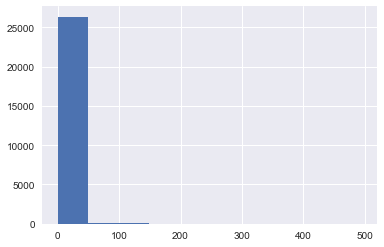

In [9]:
# Most observations have up votes near 0, and only a few with very high scores 
# resulting in very skewed data 

plt.hist('ups', data=reddit[reddit.ups <= 500])

(array([  3699.,  15301.,   2784.,   1306.,    542.,    482.,    373.,
           286.,    201.,    144.,    130.,    106.,     92.,     80.,
            71.,     67.,     53.,     42.,     46.,     83.]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.]),
 <a list of 20 Patch objects>)

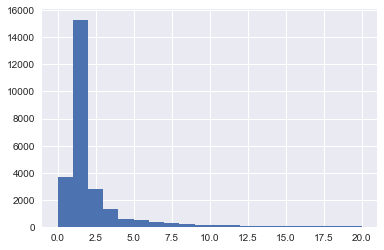

In [10]:
# when only looking at up votes under 20 still is very skewed. 

plt.hist('ups', data=reddit[reddit.ups <= 20], bins=20)

In [11]:
# There is no variation in this columns and won't be included in the final data set

reddit.downs.describe()

count    26688.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: downs, dtype: float64

In [12]:
# There is too little variation and too few observations to include in the final dataset

reddit.gilded.value_counts()

0.0    26678
1.0        8
6.0        1
2.0        1
Name: gilded, dtype: int64

In [13]:
# There is no variation and won't be included

reddit.hide_score.value_counts()

False    26688
Name: hide_score, dtype: int64

In [14]:
# not enough variation to include

reddit.contest_mode.value_counts()

False    26683
True         5
Name: contest_mode, dtype: int64

In [15]:
# not enough variation to include

reddit.archived.value_counts()

False    26688
Name: archived, dtype: int64

In [16]:
# not enough variation to include

reddit.locked.value_counts()

False    26666
True        22
Name: locked, dtype: int64

In [17]:
# no variation, will not include

reddit.spoiler.value_counts()

False    26688
Name: spoiler, dtype: int64

In [18]:
# not enough variation to include

reddit.stickied.value_counts()

False    26687
True         1
Name: stickied, dtype: int64

In [19]:
reddit.is_self.value_counts()

True     24594
False     2094
Name: is_self, dtype: int64

In [20]:
reddit.thumbnail.value_counts()

self       18192
default     8480
nsfw          16
Name: thumbnail, dtype: int64

In [21]:
# too many nulls to include

reddit.link_flair_css_class.isnull().sum()

22396

In [22]:
# columns that don't have enough variation or too many nulls in them have not been included in the new reddit df,
# dataframe has also been reordered to show the columns of interest near the left
# did not include link_flair_css_class because the same information is in link_flair_text

reddit = reddit[['subreddit', 'ups', 'title', 'selftext', 'edited', 'is_self', 'link_flair_text', 'thumbnail']]

In [23]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26688 entries, 0 to 26687
Data columns (total 8 columns):
subreddit          26688 non-null object
ups                26688 non-null float64
title              26688 non-null object
selftext           26688 non-null object
edited             26688 non-null object
is_self            26688 non-null bool
link_flair_text    4610 non-null object
thumbnail          26688 non-null object
dtypes: bool(1), float64(1), object(6)
memory usage: 1.5+ MB


In [24]:
reddit.link_flair_text.fillna(0, inplace=True)

In [25]:
reddit.head()

,subreddit,ups,title,selftext,edited,is_self,link_flair_text,thumbnail
0,techsupport,1.0,Help with audio set-up,I have a Sony surround sound system for a blu-...,False,True,0,self
1,learnprogramming,23.0,Optimizing code for speed,I've written what seems to be a prohibitively ...,False,True,0,self
2,gamedev,12.0,Seeking Tales of Development Woe (and Triumph)...,"I'm writing an article called ""Video Games Tha...",False,True,Discussion,self
3,learnprogramming,0.0,[Java] Finding smallest value in an array,[deleted],1480698462,True,Solved,default
4,learnpython,6.0,currying functions using functools,I have the following representation of argumen...,1480709138,True,0,self


In [26]:
reddit.shape

(26688, 8)

Deleting all observations where the text of the post has been deleted or removed. Deleted is by the user and Removed is by the website. 

In [27]:
reddit[reddit.selftext == '[deleted]'].shape

(5269, 8)

In [28]:
reddit[reddit.selftext == '[removed]'].shape

(3211, 8)

In [29]:
reddit = reddit[reddit.selftext != '[deleted]']
reddit = reddit[reddit.selftext != '[removed]']
reddit.shape

(18208, 8)

## Determining y

This model will use the title and text of the post to predict the subreddit it belongs to. To do this a some subreddits will be combined to broader categories. 
The remaining subreddits that have more than 1,000 observations will be included in the final dataset, and each subreddit predicted based on the words in the text of the post. 

In [30]:
[reddit.subreddit.value_counts()]

[techsupport         9569
 learnprogramming    2710
 learnpython         1425
 gamedev              804
 web_design           445
 javahelp             422
 javascript           404
 csshelp              299
 Python               276
 iOSProgramming       262
 linux                227
 engineering          213
 swift                189
 computerscience      126
 django               111
 PHP                   84
 css                   77
 java                  76
 HTML                  75
 ruby                  67
 flask                 62
 compsci               43
 technology            42
 cpp                   34
 html5                 33
 pygame                32
 jquery                29
 perl                  21
 lisp                  14
 programmer             9
 dailyprogrammer        9
 IPython                8
 inventwithpython       5
 netsec                 4
 pystats                2
 Name: subreddit, dtype: int64]

In [31]:
# resets the subreddits to be more inclusive

sub_list = []
for x in reddit.subreddit:
    if 'ython' in x or 'pygame' in x or 'pystats' in x or 'flask' in x:
        x = 'python'
        sub_list.append(x)
    elif x == 'java' or x == 'javahelp':
        x = 'java'
        sub_list.append(x)  
    elif 'program' in x:
        x = 'programming'
        sub_list.append(x)
    elif x == 'html5':
        x = 'HTML'
        sub_list.append(x)
    elif 'css' in x:
        x =  'css'
        sub_list.append(x)
    else:
        sub_list.append(x)

In [32]:
reddit.subreddit = sub_list

In [33]:
# list of top subreddits

sub = pd.DataFrame(reddit.subreddit.value_counts())

sub = sub.loc[sub['subreddit'] >= 1000]
sub_li = list(sub.index)
sub_li

['techsupport', 'programming', 'python']

In [34]:
# data set now only contains observations of the subreddits with more than 1,000 instances

reddit = reddit[(reddit.subreddit == 'techsupport') | (reddit.subreddit == 'programming') | 
                (reddit.subreddit == 'python')]

In [35]:
reddit.shape

(14107, 8)

In [36]:
reddit.head()

,subreddit,ups,title,selftext,edited,is_self,link_flair_text,thumbnail
0,techsupport,1.0,Help with audio set-up,I have a Sony surround sound system for a blu-...,False,True,0,self
1,programming,23.0,Optimizing code for speed,I've written what seems to be a prohibitively ...,False,True,0,self
4,python,6.0,currying functions using functools,I have the following representation of argumen...,1480709138,True,0,self
5,programming,1.0,Text Editor integration,I am about to create a website where users use...,False,True,0,self
7,python,8.0,What are some ways to learn efficient python?,This [post](https://www.reddit.com/r/learnpyth...,False,True,0,self


### Binerizing Featuers

In [37]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14107 entries, 0 to 26686
Data columns (total 8 columns):
subreddit          14107 non-null object
ups                14107 non-null float64
title              14107 non-null object
selftext           14107 non-null object
edited             14107 non-null object
is_self            14107 non-null bool
link_flair_text    14107 non-null object
thumbnail          14107 non-null object
dtypes: bool(1), float64(1), object(6)
memory usage: 895.5+ KB


In [38]:
# turn boolean and object columns into binary features

reddit.is_self = reddit.is_self.apply(lambda x: 0 if  x == False else 1)

reddit.edited = reddit.edited.apply(lambda x: 0 if x == 'False' else 1)

reddit.link_flair_text = reddit.link_flair_text.apply(lambda x: 1 if x == 'Solved' else 0)

reddit.thumbnail = reddit.thumbnail.apply(lambda x: 1 if x == 'self' else 0)

In [39]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14107 entries, 0 to 26686
Data columns (total 8 columns):
subreddit          14107 non-null object
ups                14107 non-null float64
title              14107 non-null object
selftext           14107 non-null object
edited             14107 non-null int64
is_self            14107 non-null int64
link_flair_text    14107 non-null int64
thumbnail          14107 non-null int64
dtypes: float64(1), int64(4), object(3)
memory usage: 991.9+ KB


### Dealing with outliers

The up votes of the posts give relevant information, however the outliers distort modeling. All votes post with 4 upvotes or more will be represented as 4.

In [40]:
reddit.ups = reddit.ups.apply(lambda x: x if x <= 3 else 4)

In [41]:
reddit.ups.describe()

count    14107.000000
mean         1.486850
std          1.116251
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: ups, dtype: float64

In [42]:
reddit.ups.value_counts()

1.0    8611
2.0    1744
4.0    1637
0.0    1339
3.0     776
Name: ups, dtype: int64

In [43]:
reddit.ups = reddit.ups.astype(int)

## EDA Visualizations

These histograms shows how the up vote distributions vary between the subreddits, and the distribution of all the up votes together (in black).

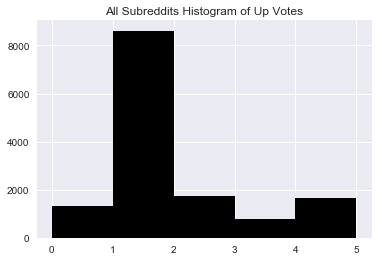

In [44]:
plt.hist('ups', data=reddit, color='black', bins=range(0,6))
plt.title('All Subreddits Histogram of Up Votes');

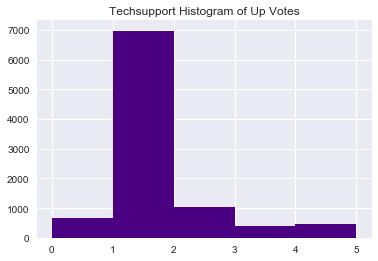

In [45]:
plt.hist('ups', data=reddit[reddit.subreddit == 'techsupport'], color='indigo', bins=range(0,6))
plt.title('Techsupport Histogram of Up Votes');

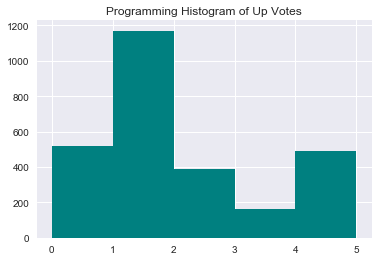

In [46]:
plt.hist('ups', data=reddit[reddit.subreddit == 'programming'], color='teal', bins=range(0,6))
plt.title('Programming Histogram of Up Votes');

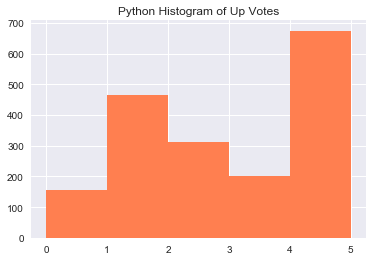

In [47]:
plt.hist('ups', data=reddit[reddit.subreddit == 'python'], color='coral', bins=range(0,6))
plt.title('Python Histogram of Up Votes');

Each subreddit has a different distrubution of upvotes, but they all have a peak at 1 upvote.

# Modeling 

Each classification it dealt with separately, the model predicts if the observation is Techsupport or not, then Programming or not, and finally Python or not.

## Techsupport Classification

These models predict if a post is in the subreddit Techsupport or not.

In [48]:
X_tech = reddit.drop('subreddit', axis=1)
y_tech = pd.DataFrame(reddit.subreddit.apply(lambda x: 1 if x == 'techsupport' else 0))

X_train_tech, X_test_tech, y_train_tech, y_test_tech = train_test_split(X_tech, y_tech, test_size=.3, random_state=42)

### Preprocessing

In [49]:
def NLP(X_train, X_test, y_train, y_test):
    
    '''Natural Lanugage Processing Function; separates title and text of posts processes 
    them, then joins them back together with other rows.'''
    
    t_vect = TfidfVectorizer(stop_words='english', max_features=1000)
    t_vect.fit(X_train['title'])
    X_train_t_tit = t_vect.transform(X_train['title'])
    X_train_t_tit = pd.DataFrame(X_train_t_tit.todense())
    X_test_t_tit = t_vect.transform(X_test['title'])
    X_test_t_tit = pd.DataFrame(X_test_t_tit.todense())    

    t_vect.fit(X_train['selftext'])
    X_train_t_text = t_vect.transform(X_train['selftext'])
    X_train_t_text = pd.DataFrame(X_train_t_text.todense())
    X_test_t_text = t_vect.transform(X_test['selftext'])
    X_test_t_text = pd.DataFrame(X_test_t_text.todense())
    
    # join the two NLP matrices from title and softtext columns, with the numeric columns 
    # reset inex of numeric columns for indices to match up 

    X_train_t = pd.concat([X_train_t_tit, X_train_t_text, X_train.drop(['title', 'selftext'], axis=1)
                           .reset_index().drop('index', axis=1)], axis=1)
    X_test_t = pd.concat([X_test_t_tit, X_test_t_text, X_test.drop(['title', 'selftext'], axis=1)
                          .reset_index().drop('index', axis=1)], axis=1)

    # combines and reduces features to 500, because of large amount of columns in output
    pca = PCA(n_components=500)

    X_train_t = pca.fit_transform(X_train_t)
    X_test_t = pca.transform(X_test_t)
    
    # reset index of y 
    y_train = y_train.reset_index().drop('index', axis=1)
    y_train = y_train.subreddit

    y_test = y_test.reset_index().drop('index', axis=1)
    y_test = y_test.subreddit
    
    return X_train_t, X_test_t, y_train, y_test

In [50]:
# call the preprocessing function to get training and testing set ready for modeling

X_train_tech, X_test_tech, y_train_tech, y_test_tech = NLP(X_train_tech, X_test_tech, y_train_tech, y_test_tech)

Basic Models to get an idea of what models to focus on, Decision Trees, Logistic Regression, and KNN Classifier

In [51]:
tree = DecisionTreeClassifier()
tree.fit(X_train_tech, y_train_tech)

baseline = y_train_tech.mean()
if baseline >= 0.5:
    print('baseline', baseline)
else:
    print('baseline', 1 - baseline)

print('cross validated train score', cross_val_score(tree, X_train_tech, y_train_tech, cv=5).mean())
print('cross validated test score', cross_val_score(tree, X_test_tech, y_test_tech, cv=5).mean())

baseline 0.6795624873404902
cross validated train score 0.927384710092
cross validated test score 0.915663916503


In [52]:
logreg = LogisticRegression()
logreg.fit(X_train_tech, y_train_tech)

baseline = y_train_tech.mean()
if baseline >= 0.5:
    print('baseline', baseline)
else:
    print('baseline', 1 - baseline)



print('cross validated train score', cross_val_score(logreg, X_train_tech, y_train_tech, cv=5).mean())
print('cross validated test score', cross_val_score(logreg, X_test_tech, y_test_tech, cv=5).mean())

baseline 0.6795624873404902
cross validated train score 0.975187154528
cross validated test score 0.968342706245


In [53]:
knn = KNeighborsClassifier()
knn.fit(X_train_tech, y_train_tech)

baseline = y_train_tech.mean()
if baseline >= 0.5:
    print('baseline', baseline)
else:
    print('baseline', 1 - baseline)

print('cross validated train score', cross_val_score(knn, X_train_tech, y_train_tech, cv=5).mean())
print('cross validated test score', cross_val_score(knn, X_test_tech, y_test_tech, cv=5).mean())

baseline 0.6795624873404902
cross validated train score 0.846465725315
cross validated test score 0.809361268103


Based on these preliminary results, the tunning will focus on the logistic regression and decision trees

### Modeling Function With Tunning

further optimize the better models with tunning

In [54]:
def forest(X_train, X_test, y_train, y_test):
    
    '''GridSearch on RandomForest Classifier'''
    
    rf = RandomForestClassifier(n_jobs=-1)
    
    params = {
        'max_features':['sqrt'],
        'n_estimators': range(10, 200),
        'max_depth': range(20, 200)
    }
    
    rand = RandomizedSearchCV(rf, param_distributions=params, verbose=3, n_jobs=-1, n_iter=20)
    
    rand.fit(X_train, y_train)
    
    print(rand.best_params_)
    
    rf = RandomForestClassifier(n_jobs=-1)
    rf.set_params(**rand.best_params_)
    
    rf.fit(X_train, y_train)

    baseline = y_train.mean()
    if baseline >= 0.5:
        print('baseline', baseline)
    else:
        print('baseline', 1 - baseline)
    
    print ('cross val train score', cross_val_score(rf, X_train, y_train, cv=5).mean())
    print ('cross val test score', cross_val_score(rf, X_test, y_test, cv=5).mean())
    
    predictions = rf.predict(X_test)
    print (confusion_matrix(y_test, predictions))
    print (classification_report(y_test, predictions))

In [55]:
def tree(X_train, X_test, y_train, y_test):
    
    tree = DecisionTreeClassifier()
    
    params = {
        'max_depth': range(2, 100, 5), 
        'max_features': ['auto', 'log2', None]
    }
    tree_rand = RandomizedSearchCV(tree, param_distributions=params, verbose=3, n_jobs=-1, cv=3)

    tree_rand.fit(X_train, y_train)

    print(tree_rand.best_params_)

    tree = DecisionTreeClassifier(**tree_rand.best_params_)
    tree.fit(X_train, y_train)
    
    baseline = y_train.mean()
    if baseline >= 0.5:
        print('baseline', baseline)
    else:
        print('baseline', 1 - baseline)
    
    print ('cross val train score', cross_val_score(tree, X_train, y_train, cv=5).mean())
    print ('cross val test score',cross_val_score(tree, X_test, y_test, cv=5).mean())
    
    predictions = tree.predict(X_test)
    print(confusion_matrix(y_test, predictions))
    print(classification_report(y_test, predictions))

In [56]:
## This gridsearch isn't able to run because of time issues, so the same optimization is done belwo manually

# def logistic(X_train, X_test, y_train, y_test):
#     logreg = LogisticRegression()
    
#     params = {'C': [1, 10, 100, 1000]}
    
#     grid = GridSearchCV(logreg, param_grid=params, verbose=3, n_jobs=-1, cv=2)
    
#     grid.fit(X_train, y_train)
    
#     print(grid.best_params_)
    
#     logreg = LogisticRegression()
#     logreg.set_params(**grid.best_params_)
    
#     logreg.fit(X_train, y_train)

#     baseline = y_train.mean()
#     if baseline >= 0.5:
#         print('baseline', baseline)
#     else:
#         print('baseline', 1 - baseline)
    
#     print ('cross val train score', cross_val_score(logreg, X_train, y_train, cv=5).mean())
#     print ('cross val test score', cross_val_score(logreg, X_test, y_test, cv=5).mean())
    
#     predictions = logreg.predict(X_test)
#     print (confusion_matrix(y_test, predictions))
#     print (classification_report(y_test, predictions))

### Logistic Regression
to tun the parameters of the logistic regression, gridsearch is not able to work effectively. So the parameters are tunned via a function below. The parameters are given the default values of the high cross val test scores

In [57]:
def log(X_train, X_test, y_train, y_test, C=1):
    logreg = LogisticRegression(C=C)
    logreg.fit(X_train, y_train)

    baseline = y_train.mean()
    if baseline >= 0.5:
        print('baseline', baseline)
    else:
        print('baseline', 1 - baseline)

    print('cross validated train score', cross_val_score(logreg, X_train, y_train, cv=5).mean())
    print('cross validated test score', cross_val_score(logreg, X_test, y_test, cv=5).mean())
    
    predictions = logreg.predict(X_test)
    print (confusion_matrix(y_test, predictions))
    print (classification_report(y_test, predictions))

In [73]:
%%time
log(X_train_tech, X_test_tech, y_train_tech, y_test_tech, C=1)

baseline 0.6795624873404902
cross validated train score 0.974984674182
cross validated test score 0.968107137618
[[1309   65]
 [  45 2814]]
             precision    recall  f1-score   support

          0       0.97      0.95      0.96      1374
          1       0.98      0.98      0.98      2859

avg / total       0.97      0.97      0.97      4233

CPU times: user 4.82 s, sys: 225 ms, total: 5.05 s
Wall time: 5.06 s


In [74]:
%%time
log(X_train_tech, X_test_tech, y_train_tech, y_test_tech, C=8)

baseline 0.6795624873404902
cross validated train score 0.9741744963
cross validated test score 0.968106019854
[[1316   58]
 [  55 2804]]
             precision    recall  f1-score   support

          0       0.96      0.96      0.96      1374
          1       0.98      0.98      0.98      2859

avg / total       0.97      0.97      0.97      4233

CPU times: user 6.78 s, sys: 239 ms, total: 7.01 s
Wall time: 7.07 s


In [75]:
%%time
log(X_train_tech, X_test_tech, y_train_tech, y_test_tech, C=10)

baseline 0.6795624873404902
cross validated train score 0.973769330409
cross validated test score 0.966924823428
[[1314   60]
 [  58 2801]]
             precision    recall  f1-score   support

          0       0.96      0.96      0.96      1374
          1       0.98      0.98      0.98      2859

avg / total       0.97      0.97      0.97      4233

CPU times: user 6.74 s, sys: 225 ms, total: 6.97 s
Wall time: 6.98 s


In [76]:
%%time
log(X_train_tech, X_test_tech, y_train_tech, y_test_tech, C=1000)

baseline 0.6795624873404902
cross validated train score 0.961109409667
cross validated test score 0.954637809743
[[1294   80]
 [  66 2793]]
             precision    recall  f1-score   support

          0       0.95      0.94      0.95      1374
          1       0.97      0.98      0.97      2859

avg / total       0.97      0.97      0.97      4233

CPU times: user 18 s, sys: 419 ms, total: 18.4 s
Wall time: 18.8 s


The highest cross val score on the test data so far is the logist regression with a C=1, when the other parameters are altered there is not effect of the score. 

### Call the randomsearch functions on randomforest and decision trees

In [ ]:
%%time
forest_grid(X_train_tech, X_test_tech, y_train_tech, y_test_tech)

In [ ]:
%%time
tree(X_train_tech, X_test_tech, y_train_tech, y_test_tech)

### Results of Techsupport

The best model by far is the Logistic Regression model so this will be used to predict the subreddits programming and python.

## Programming Classification

### Preprocessing 

In [58]:
X_pro = reddit.drop('subreddit', axis=1)
y_pro = pd.DataFrame(reddit.subreddit.apply(lambda x: 1 if x == 'programming' else 0))

X_train_pro, X_test_pro, y_train_pro, y_test_pro = train_test_split(X_pro, y_pro, test_size=.3, random_state=42)

# call preprocessing NLP function

X_train_pro, X_test_pro, y_train_pro, y_test_pro = NLP(X_train_pro, X_test_pro, y_train_pro, y_test_pro)

### Logistic Regression

In [59]:
log(X_train_pro, X_test_pro, y_train_pro, y_test_pro, C=8)

baseline 0.8061575855782864
cross validated train score 0.921915432265
cross validated test score 0.914957769503
[[3280  139]
 [ 192  622]]
             precision    recall  f1-score   support

          0       0.94      0.96      0.95      3419
          1       0.82      0.76      0.79       814

avg / total       0.92      0.92      0.92      4233



In [80]:
log(X_train_pro, X_test_pro, y_train_pro, y_test_pro, C=10)

baseline 0.8061575855782864
cross validated train score 0.921915175766
cross validated test score 0.910470787953
[[3280  139]
 [ 189  625]]
             precision    recall  f1-score   support

          0       0.95      0.96      0.95      3419
          1       0.82      0.77      0.79       814

avg / total       0.92      0.92      0.92      4233



In [81]:
log(X_train_pro, X_test_pro, y_train_pro, y_test_pro, C=100)

baseline 0.8061575855782864
cross validated train score 0.916648942583
cross validated test score 0.893934596872
[[3266  153]
 [ 181  633]]
             precision    recall  f1-score   support

          0       0.95      0.96      0.95      3419
          1       0.81      0.78      0.79       814

avg / total       0.92      0.92      0.92      4233



In [82]:
log(X_train_pro, X_test_pro, y_train_pro, y_test_pro, C=1000)

baseline 0.8061575855782864
cross validated train score 0.914623472228
cross validated test score 0.877391140328
[[3261  158]
 [ 181  633]]
             precision    recall  f1-score   support

          0       0.95      0.95      0.95      3419
          1       0.80      0.78      0.79       814

avg / total       0.92      0.92      0.92      4233



for the purposes of being complete, the programming classification will also go through the other model functions

In [ ]:
forest_grid(X_train_pro, X_test_pro, y_train_pro, y_test_pro)

In [ ]:
tree(X_train_pro, X_test_pro, y_train_pro, y_test_pro)

The model the procissed the best results in the logistic regression. 

## Python Classification

In [60]:
X_py = reddit.drop('subreddit', axis=1)
y_py = pd.DataFrame(reddit.subreddit.apply(lambda x: 1 if x == 'python' else 0))

X_train_py, X_test_py, y_train_py, y_test_py = train_test_split(X_py, y_py, test_size=.3, random_state=42)

In [61]:
# call preprocessing NLP function

X_train_py, X_test_py, y_train_py, y_test_py = NLP(X_train_py, X_test_py, y_train_py, y_test_py)

In [85]:
log(X_train_py, X_test_py, y_train_py, y_test_py, C=1)

baseline 0.8734049017622038
cross validated train score 0.936398650815
cross validated test score 0.921097406784
[[3605   68]
 [ 217  343]]
             precision    recall  f1-score   support

          0       0.94      0.98      0.96      3673
          1       0.83      0.61      0.71       560

avg / total       0.93      0.93      0.93      4233



In [62]:
log(X_train_py, X_test_py, y_train_py, y_test_py, C=10)

baseline 0.8734049017622038
cross validated train score 0.936802995909
cross validated test score 0.928657673725
[[3588   85]
 [ 191  369]]
             precision    recall  f1-score   support

          0       0.95      0.98      0.96      3673
          1       0.81      0.66      0.73       560

avg / total       0.93      0.93      0.93      4233



In [87]:
log(X_train_py, X_test_py, y_train_py, y_test_py, C=100)

baseline 0.8734049017622038
cross validated train score 0.93234642761
cross validated test score 0.91684459963
[[3572  101]
 [ 178  382]]
             precision    recall  f1-score   support

          0       0.95      0.97      0.96      3673
          1       0.79      0.68      0.73       560

avg / total       0.93      0.93      0.93      4233



In [88]:
log(X_train_py, X_test_py, y_train_py, y_test_py, C=1000)

baseline 0.8734049017622038
cross validated train score 0.929206776705
cross validated test score 0.896530376995
[[3572  101]
 [ 179  381]]
             precision    recall  f1-score   support

          0       0.95      0.97      0.96      3673
          1       0.79      0.68      0.73       560

avg / total       0.93      0.93      0.93      4233



for the purposes of being complete, the programming classification will also go through the other model functions

In [ ]:
forest_grid(X_train_py, X_test_py, y_train_py, y_test_py)

In [ ]:
tree(X_train_py, X_test_py, y_train_py, y_test_py)

### Analysis 

The best model turned out to be the logistic regression with parameter C = 8. 
It preformed better than the KNN classifier and the Decision Tree, and Randomforest, both when they were optimized with grid search. Every model preformed much higher than the Baseline.

The best accuracy score on the test data from the Logistic Regression for predicting 
- 0.9681 Techsupport 
- 0.9149 Programming
- 0.9286 Python      

All these scores are above the base line.

##  Bonus - Neural Networks

In [86]:
from sklearn.datasets import fetch_lfw_people, load_boston, load_breast_cancer, load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

First I create simple neural networks to the classify the data in the same way. The first is where the subreddit is Techsupport or not.  

### Techsupport

In [64]:
X = reddit.drop('subreddit', axis=1)
y = reddit.subreddit.apply(lambda x: 1 if x == 'techsupport' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
X_train, X_test, y_train, y_test = NLP(X_train, X_test, y_train, y_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()
model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25)

Train on 9874 samples, validate on 4233 samples
Epoch 1/25
9874/9874 [==============================] - 4s 362us/step - loss: 0.1982 - acc: 0.9163 - val_loss: 0.0822 - val_acc: 0.9717
Epoch 2/25
9874/9874 [==============================] - 3s 279us/step - loss: 0.0533 - acc: 0.9828 - val_loss: 0.1002 - val_acc: 0.9665
Epoch 3/25
9874/9874 [==============================] - 3s 285us/step - loss: 0.0350 - acc: 0.9887 - val_loss: 0.1041 - val_acc: 0.9681
Epoch 4/25
9874/9874 [==============================] - 3s 315us/step - loss: 0.0199 - acc: 0.9936 - val_loss: 0.1178 - val_acc: 0.9662
Epoch 5/25
9874/9874 [==============================] - 3s 306us/step - loss: 0.0186 - acc: 0.9942 - val_loss: 0.1233 - val_acc: 0.9698
Epoch 6/25
9874/9874 [==============================] - 3s 303us/step - loss: 0.0106 - acc: 0.9968 - val_loss: 0.1378 - val_acc: 0.9688
Epoch 7/25
9874/9874 [==============================] - 3s 311us/step - loss: 0.0125 - acc: 0.9948 - val_loss: 0.1458 - val_acc: 0.9683


In [88]:
pred = model.predict(X_test)
pred_tech = []
for x in pred:
    if x <= .5:
        x = 0
        pred_tech.append(x)
    else:
        x = 1
        pred_tech.append(x)

print('accuracy score', accuracy_score(y_test, pred_tech))        
        
print (confusion_matrix(y_test, pred_tech))

print (classification_report(y_test, pred_tech))

accuracy score 0.969525159461
[[1309   65]
 [  64 2795]]
             precision    recall  f1-score   support

          0       0.95      0.95      0.95      1374
          1       0.98      0.98      0.98      2859

avg / total       0.97      0.97      0.97      4233



The accuracy score is a slight improvement from the Logstics Regression. 
Logistic Regression was 0.9681 compared to 0.9695 for the Neural Network.

### Programming

In [89]:
X = reddit.drop('subreddit', axis=1)
y = reddit.subreddit.apply(lambda x: 1 if x == 'programming' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
X_train, X_test, y_train, y_test = NLP(X_train, X_test, y_train, y_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()
model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25)

Train on 9874 samples, validate on 4233 samples
Epoch 1/25
9874/9874 [==============================] - 4s 366us/step - loss: 0.2806 - acc: 0.8804 - val_loss: 0.1898 - val_acc: 0.9180
Epoch 2/25
9874/9874 [==============================] - 3s 324us/step - loss: 0.1421 - acc: 0.9435 - val_loss: 0.1835 - val_acc: 0.9218
Epoch 3/25
9874/9874 [==============================] - 3s 313us/step - loss: 0.1049 - acc: 0.9593 - val_loss: 0.1941 - val_acc: 0.9187
Epoch 4/25
9874/9874 [==============================] - 3s 298us/step - loss: 0.0758 - acc: 0.9689 - val_loss: 0.2310 - val_acc: 0.9206
Epoch 5/25
9874/9874 [==============================] - 3s 303us/step - loss: 0.0537 - acc: 0.9791 - val_loss: 0.2775 - val_acc: 0.9173
Epoch 6/25
9874/9874 [==============================] - 3s 313us/step - loss: 0.0386 - acc: 0.9858 - val_loss: 0.2906 - val_acc: 0.9161
Epoch 7/25
9874/9874 [==============================] - 3s 312us/step - loss: 0.0284 - acc: 0.9897 - val_loss: 0.3236 - val_acc: 0.9164


In [90]:
pred = model.predict(X_test)
pred_pro = []
for x in pred:
    if x <= .5:
        x = 0
        pred_pro.append(x)
    else:
        x = 1
        pred_pro.append(x)

print('accuracy score', accuracy_score(y_test, pred_pro))        
        
print (confusion_matrix(y_test, pred_pro))

print (classification_report(y_test, pred_pro))

accuracy score 0.918025041342
[[3267  152]
 [ 195  619]]
             precision    recall  f1-score   support

          0       0.94      0.96      0.95      3419
          1       0.80      0.76      0.78       814

avg / total       0.92      0.92      0.92      4233



The accuracy score for this neural network almost identical to the score of Logistic regression. Logistic Regression was 0.9149 compared to 0.9180 for the nueral network. 

### Python

In [91]:
X = reddit.drop('subreddit', axis=1)
y = reddit.subreddit.apply(lambda x: 1 if x == 'python' else 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
X_train, X_test, y_train, y_test = NLP(X_train, X_test, y_train, y_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

model = Sequential()
model.add(Dense(X_train.shape[1], input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dropout(.5))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25)

Train on 9874 samples, validate on 4233 samples
Epoch 1/25
9874/9874 [==============================] - 4s 375us/step - loss: 0.2069 - acc: 0.9175 - val_loss: 0.1644 - val_acc: 0.9279
Epoch 2/25
9874/9874 [==============================] - 3s 320us/step - loss: 0.1129 - acc: 0.9548 - val_loss: 0.1495 - val_acc: 0.9343
Epoch 3/25
9874/9874 [==============================] - 3s 301us/step - loss: 0.0840 - acc: 0.9659 - val_loss: 0.1584 - val_acc: 0.9360
Epoch 4/25
9874/9874 [==============================] - 3s 319us/step - loss: 0.0605 - acc: 0.9759 - val_loss: 0.1925 - val_acc: 0.9372
Epoch 5/25
9874/9874 [==============================] - 3s 304us/step - loss: 0.0420 - acc: 0.9839 - val_loss: 0.2245 - val_acc: 0.9317
Epoch 6/25
9874/9874 [==============================] - 3s 326us/step - loss: 0.0278 - acc: 0.9902 - val_loss: 0.2888 - val_acc: 0.9324
Epoch 7/25
9874/9874 [==============================] - 3s 336us/step - loss: 0.0194 - acc: 0.9943 - val_loss: 0.3080 - val_acc: 0.9350


In [92]:
pred = model.predict(X_test)
pred_py = []
for x in pred:
    if x <= .5:
        x = 0
        pred_py.append(x)
    else:
        x = 1
        pred_py.append(x)

print('accuracy score', accuracy_score(y_test, pred_py))        
        
print (confusion_matrix(y_test, pred_py))

print (classification_report(y_test, pred_py))

accuracy score 0.933853059296
[[3545  128]
 [ 152  408]]
             precision    recall  f1-score   support

          0       0.96      0.97      0.96      3673
          1       0.76      0.73      0.74       560

avg / total       0.93      0.93      0.93      4233



Predicting if the subreddit was in the python category had the biggest difference in using a logistic regression model and the neural network. The Logistic Regression Score was 0.9286 and the neural network improved that score to 0.9338. 

### Neural Network predicting all three classes together

In [99]:
X = reddit.drop('subreddit', axis=1)
y = pd.DataFrame(reddit.subreddit.apply(lambda x: 2 if x == 'techsupport' else (1 if x =='programming' else 0)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
X_train, X_test, y_train, y_test_ = NLP(X_train, X_test, y_train, y_test)


y_train = to_categorical(y_train)
y_test = to_categorical(y_test_)

X_train.shape, y_train.shape

((9874, 500), (9874, 3))

In [100]:
model = Sequential()
model.add(Dense(100, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(30, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30)

Train on 9874 samples, validate on 4233 samples
Epoch 1/30
9874/9874 [==============================] - 2s 187us/step - loss: 0.5899 - acc: 0.7498 - val_loss: 0.2718 - val_acc: 0.8868
Epoch 2/30
9874/9874 [==============================] - 1s 120us/step - loss: 0.2333 - acc: 0.9031 - val_loss: 0.2054 - val_acc: 0.9194
Epoch 3/30
9874/9874 [==============================] - 1s 120us/step - loss: 0.1782 - acc: 0.9307 - val_loss: 0.1960 - val_acc: 0.9223
Epoch 4/30
9874/9874 [==============================] - 1s 122us/step - loss: 0.1560 - acc: 0.9375 - val_loss: 0.1991 - val_acc: 0.9235
Epoch 5/30
9874/9874 [==============================] - 1s 124us/step - loss: 0.1426 - acc: 0.9455 - val_loss: 0.1992 - val_acc: 0.9206
Epoch 6/30
9874/9874 [==============================] - 1s 120us/step - loss: 0.1236 - acc: 0.9519 - val_loss: 0.1995 - val_acc: 0.9242
Epoch 7/30
9874/9874 [==============================] - 1s 134us/step - loss: 0.1157 - acc: 0.9555 - val_loss: 0.2113 - val_acc: 0.9190


In [115]:
pred_tot = model.predict_classes(X_test)

In [116]:
y_test_ = np.array(y_test_)

In [117]:
y_test_

array([2, 2, 1, ..., 2, 2, 2])

In [118]:
pred_tot

array([2, 2, 1, ..., 2, 2, 2])

In [119]:
print('accuracy score', accuracy_score(y_test_, pred_tot))        
        
print (confusion_matrix(y_test_, pred_tot))

print (classification_report(y_test_, pred_tot))

accuracy score 0.916843845972
[[ 376  170   14]
 [  67  701   46]
 [   7   48 2804]]
             precision    recall  f1-score   support

          0       0.84      0.67      0.74       560
          1       0.76      0.86      0.81       814
          2       0.98      0.98      0.98      2859

avg / total       0.92      0.92      0.92      4233



In general the neural networks improved on the logistic regression, but not by a significant amount.